In [54]:
import xarray as xr
import matplotlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
from netCDF4 import Dataset
import matplotlib.patches as mpatches
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [68]:
%matplotlib inline

In [56]:
from Carolina_Fonts_v1 import Open_Sans
Open_Sans()

In [57]:
def plot_month(lons, lats, data, cmap, title, plotgrid, dataset, proj, label, vmin, vmax, 
               cartopy_xlim=None, cartopy_ylim=None, padding=1.05):
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
    fig = plt.figure(figsize = (20, 5))
    axes_class = (GeoAxes, dict(map_projection=proj))
            
    grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=plotgrid,
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode
    
    levels = np.linspace(vmin, vmax, 10+1)
    for i, ax in enumerate(grid):
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        #ax.add_feature(cfeature.OCEAN, alpha=0.5)
    
        if dataset=='GLEAM':
            ax.set_extent([-75, -45, -40, -13], crs=ccrs.PlateCarree())
            cf = ax.contourf(lons, lats, data[:,:,i], levels=levels, vmin=vmin, vmax=vmax,
                             transform=ccrs.PlateCarree(), cmap=cmap)
        else:
            ax.set_xlim(cartopy_xlim)
            ax.set_ylim(cartopy_ylim)
            cf = ax.contourf(to_np(lons), to_np(lats), data[i,:,:], levels=levels, vmin=vmin, vmax=vmax,
                              transform=ccrs.PlateCarree(), cmap=cmap)
        
        ax.set_title(months[i], size = 16)

    cax  = grid.cbar_axes[0]
    cb   = cax.colorbar(cf, ticks=levels)
    axis = cax.axis[cax.orientation]
    axis.label.set_text(label)
    plt.suptitle(title, size = 20, y=padding)

    
    plt.show()

In [58]:
lv = 2.5e6

# GLEAM

In [59]:
gleam_path = '/data/keeling/a/bieri2/c/gleam/'

In [60]:
gleam_ET   = xr.open_dataset(gleam_path + 
                             'E_2018_GLEAM_v3.3a.nc').sel(lat=slice(-12.7, -40.8)).sel(lon=slice(-75.6,-44.4))
gleam_SM   = xr.open_dataset(gleam_path + 
                             'SMsurf_2018_GLEAM_v3.3a.nc').sel(lat=slice(-12.7, -40.8)).sel(lon=slice(-75.6,-44.4))

In [61]:
months = gleam_ET.coords['time.month'] <= 8

In [62]:
gleam_mean_ET  = gleam_ET.sel(time=months).mean(dim='time')
gleam_mean_SM  = gleam_SM.sel(time=months).mean(dim='time')

/data/keeling/a/bieri2/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [63]:
gleam_mmean_ET = gleam_ET.groupby('time.month').mean(dim='time')
gleam_mmean_SM = gleam_SM.groupby('time.month').mean(dim='time')

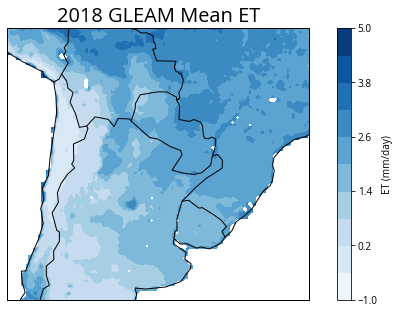

In [69]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

vmin = -1
vmax = 5
ax.set_extent([-75, -45, -40, -13], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.5)

levels = np.linspace(vmin, vmax, 10+1)
cf = ax.contourf(gleam_mean_ET['lon'], gleam_mean_ET['lat'], gleam_mean_ET['E'].T, levels=levels, vmin=vmin, vmax=vmax,
                 transform=ccrs.PlateCarree(), cmap = 'Blues')
plt.colorbar(cf, label='ET (mm/day)')
plt.title('2018 GLEAM Mean ET', size = 20)
plt.show()

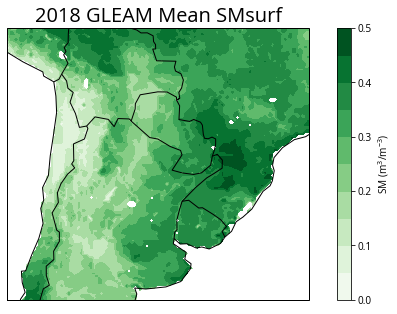

In [70]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

vmin = 0.0
vmax = 0.5
ax.set_extent([-75, -45, -40, -13], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.5)

levels = np.linspace(vmin, vmax, 10+1)
cf = ax.contourf(gleam_mean_SM['lon'], gleam_mean_SM['lat'], gleam_mean_SM['SMsurf'].T, levels=levels, vmin=vmin, vmax=vmax, 
                 transform=ccrs.PlateCarree(), cmap = 'Greens')
plt.colorbar(cf, label='SM ($m^{3}/m^{-3}$)')
plt.title('2018 GLEAM Mean SMsurf', size = 20)
plt.show()

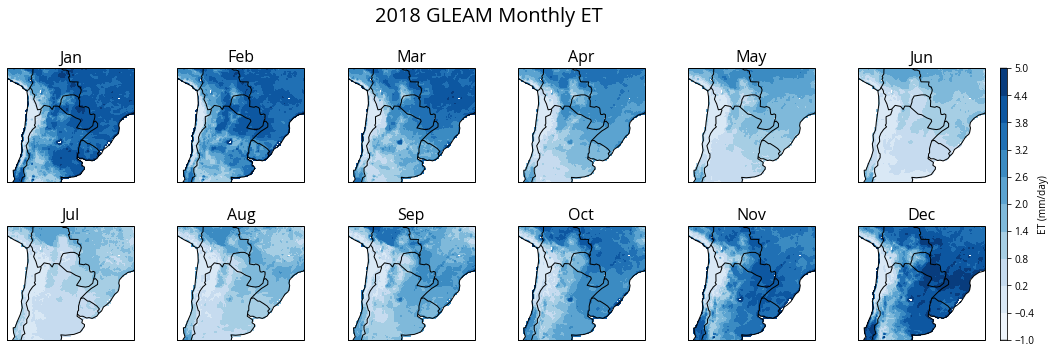

In [71]:
plot_month(gleam_mmean_ET['lon'], gleam_mmean_ET['lat'], gleam_mmean_ET['E'].T, cmap = 'Blues', 
           title = '2018 GLEAM Monthly ET', plotgrid=(2,6), proj=ccrs.PlateCarree(), dataset='GLEAM', label='ET (mm/day)', 
           vmin=-1, vmax=5)

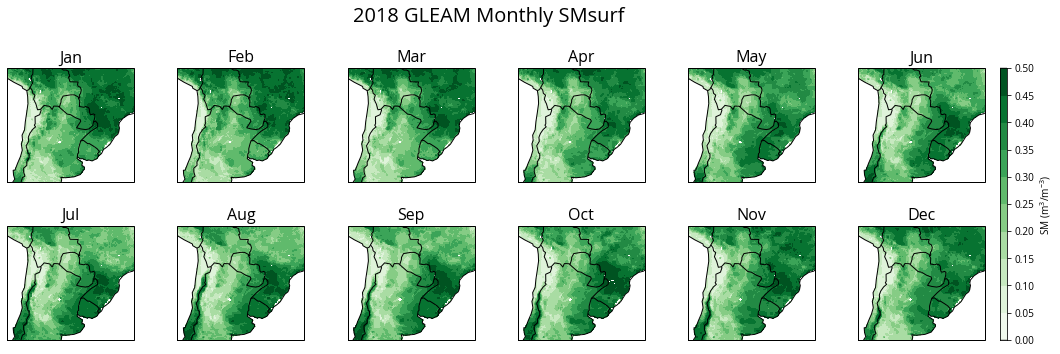

In [72]:
plot_month(gleam_mmean_SM['lon'], gleam_mmean_SM['lat'], gleam_mmean_SM['SMsurf'].T, cmap = 'Greens', 
           title = '2018 GLEAM Monthly SMsurf', plotgrid=(2,6), proj=ccrs.PlateCarree(), dataset='GLEAM', 
           label='SM ($m^{3}/m^{-3}$)', vmin=0, vmax=0.5)

# Noah-MP

In [26]:
noah_path  = '/data/keeling/a/bieri2/b/NoahMP_2D/Run/new_output/'
wrf_path   = '/data/keeling/a/bieri2/b/GLDAS_raw/geogrid/wrfinput_d01_SA'
noah_files = os.listdir(noah_path)
noah_files.sort()

In [27]:
# Open the NetCDF file
ncfile = Dataset(wrf_path)
dummy  = getvar(ncfile, "SHDMAX")
proj   = get_cartopy(dummy)
# Get the latitude and longitude points
lats, lons = latlon_coords(dummy)

In [28]:
noah_files = noah_files[:1944]

In [29]:
all_data  = []
timesteps = []
for f in noah_files:
    print('Reading ' + f)
    data = xr.open_dataset(noah_path + f, chunks={})
    all_data.append(data[['UGDRNOFF', 'HFX', 'LH', 'SOIL_M', 'ZWT']])
    timesteps.append(f[:10])

Reading 2018010100.LDASOUT_DOMAIN1
Reading 2018010103.LDASOUT_DOMAIN1
Reading 2018010106.LDASOUT_DOMAIN1
Reading 2018010109.LDASOUT_DOMAIN1
Reading 2018010112.LDASOUT_DOMAIN1
Reading 2018010115.LDASOUT_DOMAIN1
Reading 2018010118.LDASOUT_DOMAIN1
Reading 2018010121.LDASOUT_DOMAIN1
Reading 2018010200.LDASOUT_DOMAIN1
Reading 2018010203.LDASOUT_DOMAIN1
Reading 2018010206.LDASOUT_DOMAIN1
Reading 2018010209.LDASOUT_DOMAIN1
Reading 2018010212.LDASOUT_DOMAIN1
Reading 2018010215.LDASOUT_DOMAIN1
Reading 2018010218.LDASOUT_DOMAIN1
Reading 2018010221.LDASOUT_DOMAIN1
Reading 2018010300.LDASOUT_DOMAIN1
Reading 2018010303.LDASOUT_DOMAIN1
Reading 2018010306.LDASOUT_DOMAIN1
Reading 2018010309.LDASOUT_DOMAIN1
Reading 2018010312.LDASOUT_DOMAIN1
Reading 2018010315.LDASOUT_DOMAIN1
Reading 2018010318.LDASOUT_DOMAIN1
Reading 2018010321.LDASOUT_DOMAIN1
Reading 2018010400.LDASOUT_DOMAIN1
Reading 2018010403.LDASOUT_DOMAIN1
Reading 2018010406.LDASOUT_DOMAIN1
Reading 2018010409.LDASOUT_DOMAIN1
Reading 2018010412.L

Reading 2018013009.LDASOUT_DOMAIN1
Reading 2018013012.LDASOUT_DOMAIN1
Reading 2018013015.LDASOUT_DOMAIN1
Reading 2018013018.LDASOUT_DOMAIN1
Reading 2018013021.LDASOUT_DOMAIN1
Reading 2018013100.LDASOUT_DOMAIN1
Reading 2018013103.LDASOUT_DOMAIN1
Reading 2018013106.LDASOUT_DOMAIN1
Reading 2018013109.LDASOUT_DOMAIN1
Reading 2018013112.LDASOUT_DOMAIN1
Reading 2018013115.LDASOUT_DOMAIN1
Reading 2018013118.LDASOUT_DOMAIN1
Reading 2018013121.LDASOUT_DOMAIN1
Reading 2018020100.LDASOUT_DOMAIN1
Reading 2018020103.LDASOUT_DOMAIN1
Reading 2018020106.LDASOUT_DOMAIN1
Reading 2018020109.LDASOUT_DOMAIN1
Reading 2018020112.LDASOUT_DOMAIN1
Reading 2018020115.LDASOUT_DOMAIN1
Reading 2018020118.LDASOUT_DOMAIN1
Reading 2018020121.LDASOUT_DOMAIN1
Reading 2018020200.LDASOUT_DOMAIN1
Reading 2018020203.LDASOUT_DOMAIN1
Reading 2018020206.LDASOUT_DOMAIN1
Reading 2018020209.LDASOUT_DOMAIN1
Reading 2018020212.LDASOUT_DOMAIN1
Reading 2018020215.LDASOUT_DOMAIN1
Reading 2018020218.LDASOUT_DOMAIN1
Reading 2018020221.L

Reading 2018022818.LDASOUT_DOMAIN1
Reading 2018022821.LDASOUT_DOMAIN1
Reading 2018030100.LDASOUT_DOMAIN1
Reading 2018030103.LDASOUT_DOMAIN1
Reading 2018030106.LDASOUT_DOMAIN1
Reading 2018030109.LDASOUT_DOMAIN1
Reading 2018030112.LDASOUT_DOMAIN1
Reading 2018030115.LDASOUT_DOMAIN1
Reading 2018030118.LDASOUT_DOMAIN1
Reading 2018030121.LDASOUT_DOMAIN1
Reading 2018030200.LDASOUT_DOMAIN1
Reading 2018030203.LDASOUT_DOMAIN1
Reading 2018030206.LDASOUT_DOMAIN1
Reading 2018030209.LDASOUT_DOMAIN1
Reading 2018030212.LDASOUT_DOMAIN1
Reading 2018030215.LDASOUT_DOMAIN1
Reading 2018030218.LDASOUT_DOMAIN1
Reading 2018030221.LDASOUT_DOMAIN1
Reading 2018030300.LDASOUT_DOMAIN1
Reading 2018030303.LDASOUT_DOMAIN1
Reading 2018030306.LDASOUT_DOMAIN1
Reading 2018030309.LDASOUT_DOMAIN1
Reading 2018030312.LDASOUT_DOMAIN1
Reading 2018030315.LDASOUT_DOMAIN1
Reading 2018030318.LDASOUT_DOMAIN1
Reading 2018030321.LDASOUT_DOMAIN1
Reading 2018030400.LDASOUT_DOMAIN1
Reading 2018030403.LDASOUT_DOMAIN1
Reading 2018030406.L

Reading 2018033006.LDASOUT_DOMAIN1
Reading 2018033009.LDASOUT_DOMAIN1
Reading 2018033012.LDASOUT_DOMAIN1
Reading 2018033015.LDASOUT_DOMAIN1
Reading 2018033018.LDASOUT_DOMAIN1
Reading 2018033021.LDASOUT_DOMAIN1
Reading 2018033100.LDASOUT_DOMAIN1
Reading 2018033103.LDASOUT_DOMAIN1
Reading 2018033106.LDASOUT_DOMAIN1
Reading 2018033109.LDASOUT_DOMAIN1
Reading 2018033112.LDASOUT_DOMAIN1
Reading 2018033115.LDASOUT_DOMAIN1
Reading 2018033118.LDASOUT_DOMAIN1
Reading 2018033121.LDASOUT_DOMAIN1
Reading 2018040100.LDASOUT_DOMAIN1
Reading 2018040103.LDASOUT_DOMAIN1
Reading 2018040106.LDASOUT_DOMAIN1
Reading 2018040109.LDASOUT_DOMAIN1
Reading 2018040112.LDASOUT_DOMAIN1
Reading 2018040115.LDASOUT_DOMAIN1
Reading 2018040118.LDASOUT_DOMAIN1
Reading 2018040121.LDASOUT_DOMAIN1
Reading 2018040200.LDASOUT_DOMAIN1
Reading 2018040203.LDASOUT_DOMAIN1
Reading 2018040206.LDASOUT_DOMAIN1
Reading 2018040209.LDASOUT_DOMAIN1
Reading 2018040212.LDASOUT_DOMAIN1
Reading 2018040215.LDASOUT_DOMAIN1
Reading 2018040218.L

Reading 2018042821.LDASOUT_DOMAIN1
Reading 2018042900.LDASOUT_DOMAIN1
Reading 2018042903.LDASOUT_DOMAIN1
Reading 2018042906.LDASOUT_DOMAIN1
Reading 2018042909.LDASOUT_DOMAIN1
Reading 2018042912.LDASOUT_DOMAIN1
Reading 2018042915.LDASOUT_DOMAIN1
Reading 2018042918.LDASOUT_DOMAIN1
Reading 2018042921.LDASOUT_DOMAIN1
Reading 2018043000.LDASOUT_DOMAIN1
Reading 2018043003.LDASOUT_DOMAIN1
Reading 2018043006.LDASOUT_DOMAIN1
Reading 2018043009.LDASOUT_DOMAIN1
Reading 2018043012.LDASOUT_DOMAIN1
Reading 2018043015.LDASOUT_DOMAIN1
Reading 2018043018.LDASOUT_DOMAIN1
Reading 2018043021.LDASOUT_DOMAIN1
Reading 2018050100.LDASOUT_DOMAIN1
Reading 2018050103.LDASOUT_DOMAIN1
Reading 2018050106.LDASOUT_DOMAIN1
Reading 2018050109.LDASOUT_DOMAIN1
Reading 2018050112.LDASOUT_DOMAIN1
Reading 2018050115.LDASOUT_DOMAIN1
Reading 2018050118.LDASOUT_DOMAIN1
Reading 2018050121.LDASOUT_DOMAIN1
Reading 2018050200.LDASOUT_DOMAIN1
Reading 2018050203.LDASOUT_DOMAIN1
Reading 2018050206.LDASOUT_DOMAIN1
Reading 2018050209.L

Reading 2018052806.LDASOUT_DOMAIN1
Reading 2018052809.LDASOUT_DOMAIN1
Reading 2018052812.LDASOUT_DOMAIN1
Reading 2018052815.LDASOUT_DOMAIN1
Reading 2018052818.LDASOUT_DOMAIN1
Reading 2018052821.LDASOUT_DOMAIN1
Reading 2018052900.LDASOUT_DOMAIN1
Reading 2018052903.LDASOUT_DOMAIN1
Reading 2018052906.LDASOUT_DOMAIN1
Reading 2018052909.LDASOUT_DOMAIN1
Reading 2018052912.LDASOUT_DOMAIN1
Reading 2018052915.LDASOUT_DOMAIN1
Reading 2018052918.LDASOUT_DOMAIN1
Reading 2018052921.LDASOUT_DOMAIN1
Reading 2018053000.LDASOUT_DOMAIN1
Reading 2018053003.LDASOUT_DOMAIN1
Reading 2018053006.LDASOUT_DOMAIN1
Reading 2018053009.LDASOUT_DOMAIN1
Reading 2018053012.LDASOUT_DOMAIN1
Reading 2018053015.LDASOUT_DOMAIN1
Reading 2018053018.LDASOUT_DOMAIN1
Reading 2018053021.LDASOUT_DOMAIN1
Reading 2018053100.LDASOUT_DOMAIN1
Reading 2018053103.LDASOUT_DOMAIN1
Reading 2018053106.LDASOUT_DOMAIN1
Reading 2018053109.LDASOUT_DOMAIN1
Reading 2018053112.LDASOUT_DOMAIN1
Reading 2018053115.LDASOUT_DOMAIN1
Reading 2018053118.L

Reading 2018062621.LDASOUT_DOMAIN1
Reading 2018062700.LDASOUT_DOMAIN1
Reading 2018062703.LDASOUT_DOMAIN1
Reading 2018062706.LDASOUT_DOMAIN1
Reading 2018062709.LDASOUT_DOMAIN1
Reading 2018062712.LDASOUT_DOMAIN1
Reading 2018062715.LDASOUT_DOMAIN1
Reading 2018062718.LDASOUT_DOMAIN1
Reading 2018062721.LDASOUT_DOMAIN1
Reading 2018062800.LDASOUT_DOMAIN1
Reading 2018062803.LDASOUT_DOMAIN1
Reading 2018062806.LDASOUT_DOMAIN1
Reading 2018062809.LDASOUT_DOMAIN1
Reading 2018062812.LDASOUT_DOMAIN1
Reading 2018062815.LDASOUT_DOMAIN1
Reading 2018062818.LDASOUT_DOMAIN1
Reading 2018062821.LDASOUT_DOMAIN1
Reading 2018062900.LDASOUT_DOMAIN1
Reading 2018062903.LDASOUT_DOMAIN1
Reading 2018062906.LDASOUT_DOMAIN1
Reading 2018062909.LDASOUT_DOMAIN1
Reading 2018062912.LDASOUT_DOMAIN1
Reading 2018062915.LDASOUT_DOMAIN1
Reading 2018062918.LDASOUT_DOMAIN1
Reading 2018062921.LDASOUT_DOMAIN1
Reading 2018063000.LDASOUT_DOMAIN1
Reading 2018063003.LDASOUT_DOMAIN1
Reading 2018063006.LDASOUT_DOMAIN1
Reading 2018063009.L

Reading 2018072612.LDASOUT_DOMAIN1
Reading 2018072615.LDASOUT_DOMAIN1
Reading 2018072618.LDASOUT_DOMAIN1
Reading 2018072621.LDASOUT_DOMAIN1
Reading 2018072700.LDASOUT_DOMAIN1
Reading 2018072703.LDASOUT_DOMAIN1
Reading 2018072706.LDASOUT_DOMAIN1
Reading 2018072709.LDASOUT_DOMAIN1
Reading 2018072712.LDASOUT_DOMAIN1
Reading 2018072715.LDASOUT_DOMAIN1
Reading 2018072718.LDASOUT_DOMAIN1
Reading 2018072721.LDASOUT_DOMAIN1
Reading 2018072800.LDASOUT_DOMAIN1
Reading 2018072803.LDASOUT_DOMAIN1
Reading 2018072806.LDASOUT_DOMAIN1
Reading 2018072809.LDASOUT_DOMAIN1
Reading 2018072812.LDASOUT_DOMAIN1
Reading 2018072815.LDASOUT_DOMAIN1
Reading 2018072818.LDASOUT_DOMAIN1
Reading 2018072821.LDASOUT_DOMAIN1
Reading 2018072900.LDASOUT_DOMAIN1
Reading 2018072903.LDASOUT_DOMAIN1
Reading 2018072906.LDASOUT_DOMAIN1
Reading 2018072909.LDASOUT_DOMAIN1
Reading 2018072912.LDASOUT_DOMAIN1
Reading 2018072915.LDASOUT_DOMAIN1
Reading 2018072918.LDASOUT_DOMAIN1
Reading 2018072921.LDASOUT_DOMAIN1
Reading 2018073000.L

Reading 2018082503.LDASOUT_DOMAIN1
Reading 2018082506.LDASOUT_DOMAIN1
Reading 2018082509.LDASOUT_DOMAIN1
Reading 2018082512.LDASOUT_DOMAIN1
Reading 2018082515.LDASOUT_DOMAIN1
Reading 2018082518.LDASOUT_DOMAIN1
Reading 2018082521.LDASOUT_DOMAIN1
Reading 2018082600.LDASOUT_DOMAIN1
Reading 2018082603.LDASOUT_DOMAIN1
Reading 2018082606.LDASOUT_DOMAIN1
Reading 2018082609.LDASOUT_DOMAIN1
Reading 2018082612.LDASOUT_DOMAIN1
Reading 2018082615.LDASOUT_DOMAIN1
Reading 2018082618.LDASOUT_DOMAIN1
Reading 2018082621.LDASOUT_DOMAIN1
Reading 2018082700.LDASOUT_DOMAIN1
Reading 2018082703.LDASOUT_DOMAIN1
Reading 2018082706.LDASOUT_DOMAIN1
Reading 2018082709.LDASOUT_DOMAIN1
Reading 2018082712.LDASOUT_DOMAIN1
Reading 2018082715.LDASOUT_DOMAIN1
Reading 2018082718.LDASOUT_DOMAIN1
Reading 2018082721.LDASOUT_DOMAIN1
Reading 2018082800.LDASOUT_DOMAIN1
Reading 2018082803.LDASOUT_DOMAIN1
Reading 2018082806.LDASOUT_DOMAIN1
Reading 2018082809.LDASOUT_DOMAIN1
Reading 2018082812.LDASOUT_DOMAIN1
Reading 2018082815.L

In [30]:
all_data = xr.concat(all_data, dim = 'Time')

In [31]:
all_data['Time'] = ('Time', pd.to_datetime(timesteps, format = '%Y%m%d%H'))

In [32]:
all_data = all_data.assign_coords(south_north = lats['XLAT'][:,0].values, west_east = lons['XLONG'][0,:].values)

In [33]:
noah_mean_ET = all_data['LH'].mean(dim='Time')
noah_mean_ET = noah_mean_ET.where(noah_mean_ET > -1e30)

In [34]:
noah_mean_SH = all_data['HFX'].mean(dim='Time')
noah_mean_SH = noah_mean_SH.where(noah_mean_SH > -1e30)

In [35]:
noah_mean_SM = all_data['SOIL_M'].sel(soil_layers_stag=0).mean(dim='Time')
noah_mean_SM = noah_mean_SM.where(noah_mean_SM > -1e30)

In [36]:
noah_mean_WT = all_data['ZWT'].mean(dim='Time')
noah_mean_WT = noah_mean_WT.where(noah_mean_WT > -180)

In [37]:
noah_mmean_ET = all_data['LH'].groupby('Time.month').mean(dim='Time')
noah_mmean_ET = noah_mmean_ET.where(noah_mmean_ET > -1e30)

In [38]:
noah_mmean_SH = all_data['HFX'].groupby('Time.month').mean(dim='Time')
noah_mmean_SH = noah_mmean_SH.where(noah_mmean_SH > -1e30)

In [39]:
noah_mmean_SM = all_data['SOIL_M'].sel(soil_layers_stag=0).groupby('Time.month').mean(dim='Time')
noah_mmean_SM = noah_mmean_SM.where(noah_mmean_SM > -1e30)

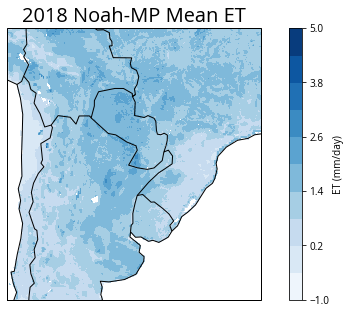

In [73]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

vmin=-1
vmax=5
ax.set_xlim(cartopy_xlim(dummy))
ax.set_ylim(cartopy_ylim(dummy))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.7)

levels = np.linspace(vmin, vmax, 10+1)
cf = ax.contourf(to_np(lons), to_np(lats), (noah_mean_ET/lv)*86400., levels=levels, vmin=vmin, vmax=vmax,
                  cmap = 'Blues', transform=ccrs.PlateCarree())
plt.colorbar(cf, label='ET (mm/day)')
plt.title('2018 Noah-MP Mean ET', size = 20)
plt.show()

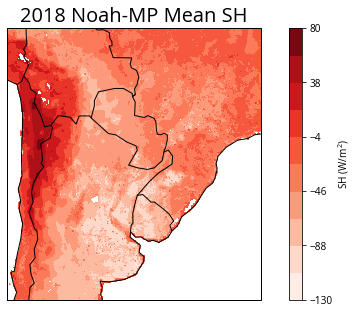

In [74]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

vmin=-130
vmax=80
ax.set_xlim(cartopy_xlim(dummy))
ax.set_ylim(cartopy_ylim(dummy))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.5)

levels = np.linspace(vmin, vmax, 10+1)
cf = ax.contourf(to_np(lons), to_np(lats), noah_mean_SH, levels=levels, vmin=vmin, vmax=vmax, 
                 transform=ccrs.PlateCarree(), cmap = 'Reds')
plt.colorbar(cf, label='SH ($W/m^{2}$)')
plt.title('2018 Noah-MP Mean SH', size = 20)
plt.show()

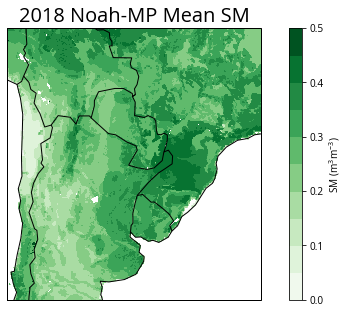

In [75]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

vmin = 0.0
vmax = 0.5
ax.set_xlim(cartopy_xlim(dummy))
ax.set_ylim(cartopy_ylim(dummy))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.5)

levels = np.linspace(vmin, vmax, 10+1)
cf = ax.contourf(to_np(lons), to_np(lats), noah_mean_SM, levels=levels, vmin=vmin, vmax=vmax, 
                 transform=ccrs.PlateCarree(), cmap = 'Greens')
plt.colorbar(cf, label='SM ($m^{3}m^{-3}$)')
plt.title('2018 Noah-MP Mean SMsurf', size = 20)
plt.show()

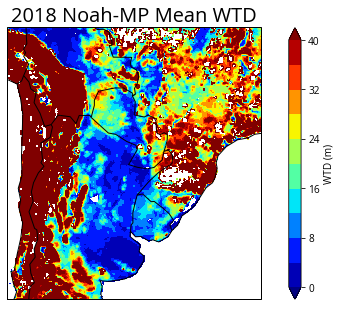

In [80]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

ax.set_xlim(cartopy_xlim(dummy))
ax.set_ylim(cartopy_ylim(dummy))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.OCEAN, alpha=0.5)

levels = np.linspace(0, 40, 10+1)
cf = ax.contourf(to_np(lons), to_np(lats), noah_mean_WT*-1, levels, vmin=0, vmax=40, 
                 transform=ccrs.PlateCarree(), cmap = 'jet', extend='both')
plt.colorbar(cf, label='WTD (m)', extend='both')
plt.title('2018 Noah-MP Mean WTD', size = 20)
plt.show()

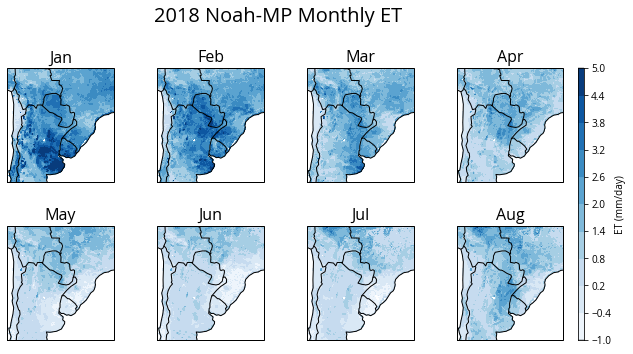

In [85]:
plot_month(lons, lats, (noah_mmean_ET/lv)*86400., cmap = 'Blues', title = '2018 Noah-MP Monthly ET', 
           plotgrid=(2,4), dataset='Noah-MP', proj=proj, label = 'ET (mm/day)', 
           vmin=-1, vmax=5, cartopy_xlim=cartopy_xlim(dummy), cartopy_ylim=cartopy_ylim(dummy))

In [ ]:
plot_month(lons, lats, noah_mmean_SH, cmap = 'Reds', 
           title = '2018 Noah-MP Monthly SH', plotgrid=(2,4), dataset='Noah-MP',proj=proj, label = 'SH ($Wm^{-2}$)',
           vmin=-130, vmax=80, cartopy_xlim=cartopy_xlim(dummy), cartopy_ylim=cartopy_ylim(dummy))

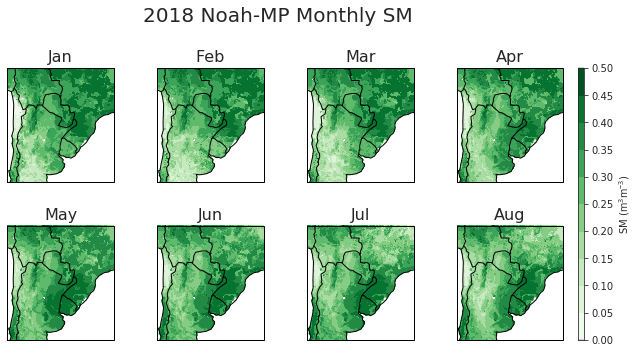

In [103]:
plot_month(lons, lats, noah_mmean_SM, cmap = 'Greens', 
           title = '2018 Noah-MP Monthly SM', plotgrid=(2,4), dataset='Noah-MP',proj=proj, label = 'SM ($m^{3}m^{-3}$)',
           vmin=0, vmax=0.5, cartopy_xlim=cartopy_xlim(dummy), cartopy_ylim=cartopy_ylim(dummy))

# Comparison

In [105]:
mj_data = all_data.sel(south_north = -32.7, west_east = -62.1, method = 'nearest')
mj_dmean_ET  = mj_data['LH'].groupby('Time.hour').mean(dim='Time')
mj_dmean_SH  = mj_data['HFX'].groupby('Time.hour').mean(dim='Time')

In [106]:
mj_damean_RF = mj_data['UGDRNOFF'].groupby('Time.dayofyear').mean(dim="Time")

In [107]:
relam = pd.read_excel('/data/keeling/a/bieri2/b/relampago_sujan_20180520_20190504_5min.xlsx').set_index('Time step')

In [108]:
relam_LH  = relam['LH'].resample('3H').mean()
relam_SH  = relam['SH'].resample('3H').mean()

In [141]:
relam_dmean_LH = relam_LH.groupby(relam_LH.index.hour).mean()
relam_dmean_SH = relam_SH.groupby(relam_SH.index.hour).mean()

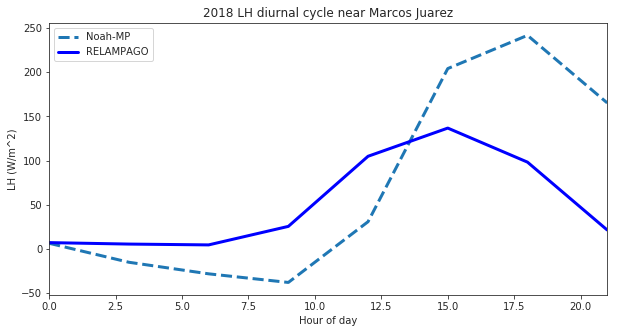

In [146]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(mj_dmean_ET['hour'], mj_dmean_ET, lw=3, linestyle='dashed', label='Noah-MP')
plt.plot(mj_dmean_ET['hour'], relam_dmean_LH, lw=3, label='RELAMPAGO', color='blue')
plt.xlim(0, 21)
plt.xlabel('Hour of day')
plt.ylabel('LH (W/m^2)')
plt.title('2018 LH diurnal cycle near Marcos Juarez')
plt.legend()
plt.show()

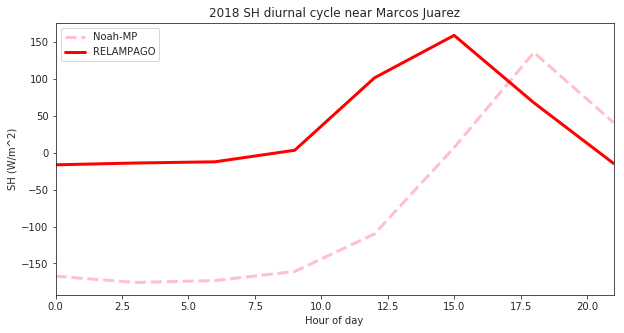

In [147]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(mj_dmean_SH['hour'], mj_dmean_SH, lw=3, linestyle='dashed', color='pink', label='Noah-MP')
plt.plot(mj_dmean_SH['hour'], relam_dmean_SH, lw=3, color='red', label='RELAMPAGO')
plt.xlim(0, 21)
plt.xlabel('Hour of day')
plt.ylabel('SH (W/m^2)')
plt.title('2018 SH diurnal cycle near Marcos Juarez')
plt.legend()
plt.show()

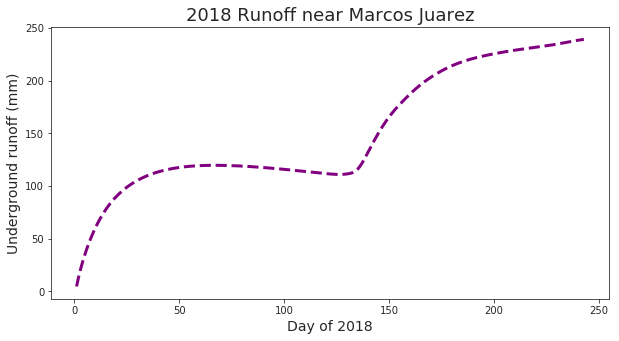

In [108]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(mj_damean_RF['dayofyear'], mj_damean_RF, lw=3, linestyle='dashed', color='purple')
#plt.xlim(0, )
plt.xlabel('Day of 2018',size=14)
plt.ylabel('Underground runoff (mm)', size=14)
plt.title('2018 Runoff near Marcos Juarez', size=18)
plt.show()

##  Ecoregion comparison

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([-75, -45, -40, -13], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.5)
xticks = [-80, -75, -70, -65, -60, -55, -50, -45]
yticks = [-40, -35, -30, -25, -20, -15, -10]
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=[-66, -31.5], width=5, height=5,
                                    color='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))

ax.add_patch(mpatches.Rectangle(xy=[-63, -38], width=4.5, height=4.5,
                                    color='red',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))

ax.add_patch(mpatches.Rectangle(xy=[-54, -27], width=5, height=5,
                                    color='green',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))

plt.text(-47, -22, 'Atlantic Forest',
         horizontalalignment='right', size=11)

plt.text(-62, -26.5, 'Chaco',
         horizontalalignment='right', size=11)

plt.text(-58.5, -33.5, 'Pampas',
         horizontalalignment='right', size=11)

#plt.title('Analysis regions', size = 15)
plt.show()

In [87]:
noah_ch_ET = all_data['LH'].sel(south_north=slice(-31.5,-26.5), west_east=slice(-66,-61))
noah_pa_ET = all_data['LH'].sel(south_north=slice(-38,-33.5), west_east=slice(-63,-58.5))
noah_af_ET = all_data['LH'].sel(south_north=slice(-27,-22), west_east=slice(-54,-49))

In [88]:
gleam_ch_ET = gleam_ET['E'].sel(lat=slice(-26.5,-31.5), lon=slice(-66,-61))
gleam_pa_ET = gleam_ET['E'].sel(lat=slice(-33.5,-38), lon=slice(-63,-58.5))
gleam_af_ET = gleam_ET['E'].sel(lat=slice(-22,-27), lon=slice(-54,-49))

In [89]:
noah_ch_ET = noah_ch_ET.where(noah_ch_ET > -1e30)
noah_pa_ET = noah_pa_ET.where(noah_pa_ET > -1e30)
noah_af_ET = noah_af_ET.where(noah_af_ET > -1e30)

In [90]:
noah_ch_smean_ET  = noah_ch_ET.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')
noah_pa_smean_ET  = noah_pa_ET.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')
noah_af_smean_ET  = noah_af_ET.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')

In [91]:
gleam_ch_smean_ET = gleam_ch_ET.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')
gleam_pa_smean_ET = gleam_pa_ET.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')
gleam_af_smean_ET = gleam_af_ET.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')

/data/keeling/a/bieri2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/bieri2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


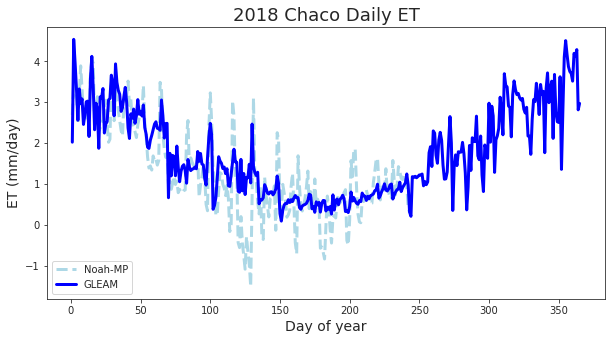

In [92]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_ch_smean_ET['dayofyear'], (noah_ch_smean_ET/lv)*86400, lw=3, linestyle='dashed', color='lightblue', 
         label='Noah-MP')
plt.plot(gleam_ch_smean_ET['dayofyear'], gleam_ch_smean_ET, lw=3, color='blue', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('ET (mm/day)', size=14)
plt.title('2018 Chaco Daily ET', size=18)
plt.legend()
plt.show()

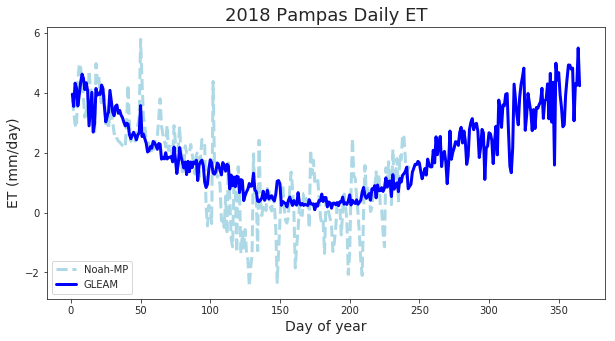

In [93]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_pa_smean_ET['dayofyear'], (noah_pa_smean_ET/lv)*86400, lw=3, linestyle='dashed', color='lightblue',
         label='Noah-MP')
plt.plot(gleam_pa_smean_ET['dayofyear'], gleam_pa_smean_ET, lw=3, color='blue', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('ET (mm/day)', size=14)
plt.title('2018 Pampas Daily ET', size=18)
plt.legend()
plt.show()

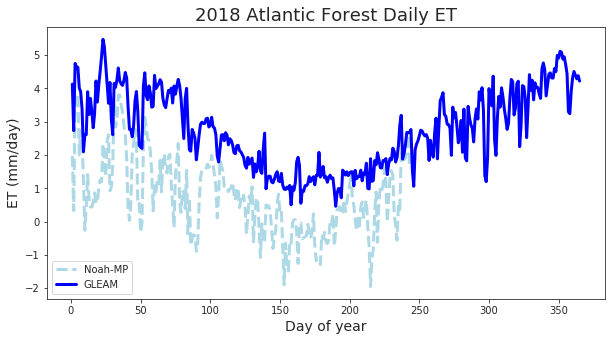

In [94]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_af_smean_ET['dayofyear'], (noah_af_smean_ET/lv)*86400, lw=3, linestyle='dashed', color='lightblue',
         label='Noah-MP')
plt.plot(gleam_af_smean_ET['dayofyear'], gleam_af_smean_ET, lw=3, color='blue', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('ET (mm/day)', size=14)
plt.title('2018 Atlantic Forest Daily ET', size=18)
plt.legend()
plt.show()

In [95]:
noah_ch_SM = all_data['SOIL_M'].sel(south_north=slice(-31.5,-26.5), west_east=slice(-66,-61), soil_layers_stag=0)
noah_pa_SM = all_data['SOIL_M'].sel(south_north=slice(-38,-33.5), west_east=slice(-63,-58.5), soil_layers_stag=0)
noah_af_SM = all_data['SOIL_M'].sel(south_north=slice(-27,-22), west_east=slice(-54,-49), soil_layers_stag=0)

In [96]:
gleam_ch_SM = gleam_SM['SMsurf'].sel(lat=slice(-26.5,-31.5), lon=slice(-66,-61))
gleam_pa_SM = gleam_SM['SMsurf'].sel(lat=slice(-33.5,-38), lon=slice(-63,-58.5))
gleam_af_SM = gleam_SM['SMsurf'].sel(lat=slice(-22,-27), lon=slice(-54,-49))

In [97]:
noah_ch_SM = noah_ch_SM.where(noah_ch_SM > -1e30)
noah_pa_SM = noah_pa_SM.where(noah_pa_SM > -1e30)
noah_af_SM = noah_af_SM.where(noah_af_SM > -1e30)

In [98]:
noah_ch_smean_SM  = noah_ch_SM.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')
noah_pa_smean_SM  = noah_pa_SM.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')
noah_af_smean_SM  = noah_af_SM.groupby('Time.dayofyear').mean(dim='Time').mean(dim='south_north').mean(dim='west_east')

In [99]:
gleam_ch_smean_SM = gleam_ch_SM.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')
gleam_pa_smean_SM = gleam_pa_SM.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')
gleam_af_smean_SM = gleam_af_SM.groupby('time.dayofyear').mean(dim='time').mean(dim='lat').mean(dim='lon')

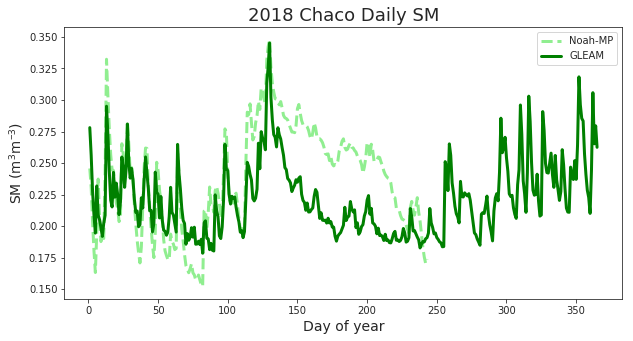

In [100]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_ch_smean_SM['dayofyear'], noah_ch_smean_SM, lw=3, linestyle='dashed', color='lightgreen', label='Noah-MP')
plt.plot(gleam_ch_smean_SM['dayofyear'], gleam_ch_smean_SM, lw=3, color='green', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('SM ($m^{3}m^{-3}$)', size=14)
plt.title('2018 Chaco Daily SM', size=18)
plt.legend()
plt.show()

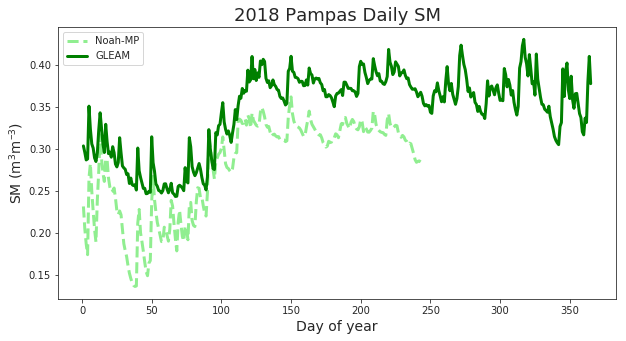

In [101]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_pa_smean_SM['dayofyear'], noah_pa_smean_SM, lw=3, linestyle='dashed', color='lightgreen', label='Noah-MP')
plt.plot(gleam_pa_smean_SM['dayofyear'], gleam_pa_smean_SM, lw=3, color='green', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('SM ($m^{3}m^{-3}$)', size=14)
plt.title('2018 Pampas Daily SM', size=18)
plt.legend()
plt.show()

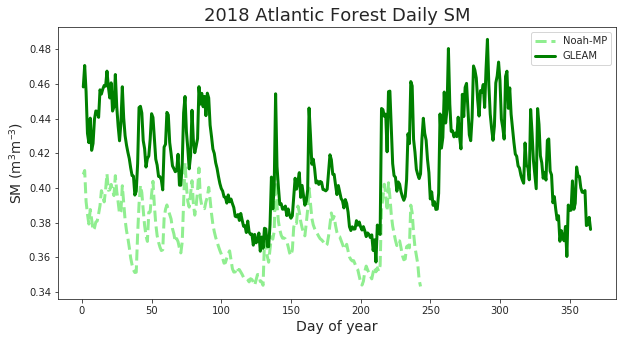

In [102]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
plt.plot(noah_af_smean_SM['dayofyear'], noah_af_smean_SM, lw=3, linestyle='dashed', color='lightgreen', label='Noah-MP')
plt.plot(gleam_af_smean_SM['dayofyear'], gleam_af_smean_SM, lw=3, color='green', label='GLEAM')
#plt.xlim(0, 21)
plt.xlabel('Day of year', size=14)
plt.ylabel('SM ($m^{3}m^{-3}$)', size=14)
plt.title('2018 Atlantic Forest Daily SM', size=18)
plt.legend()
plt.show()